### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

### Load California Housing Dataset

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
# view first 5 rows of the dataframe
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Dataset Overview and Exploratory Data Analysis

In [4]:
# get the shape (i.e. number of rows and columns) of the dataset
print(df.shape)

# get info. of the dataset
print(df.info()) 

# get statistical values of the numerical data
print(df.describe())

# check for nulls
print(df.isnull().sum())

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532  

In [5]:
# calculate the % null in total_bedrooms feature
prct_null = df['total_bedrooms'].isnull().sum() / len(df['total_bedrooms']) * 100
prct_null

np.float64(1.002906976744186)

Based on the information above, the following can be noted:

- There are null values observed in the total_bedrooms feature. This feature is only missing about **1%** of the data.
- The dataset is in numerical values except for ocean_proximity feature and therefore needs to be converted to numerical values prior to modelling.
- Further investigate the relationship between the target variable and features.
- There seems to be some outliers within our dataset which requires further investigation.

**Removing null values**

In [6]:
# since only about 1% of the data is null, it is safe to drop these.
df = df.dropna(subset='total_bedrooms', axis=0)

# confirming the dropped null values
print(df.shape)
print(df.isnull().sum())

(20433, 10)
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


**Further investigate ocean_proximity feature**

In [7]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

<Axes: xlabel='Ocean Proximity Categories'>

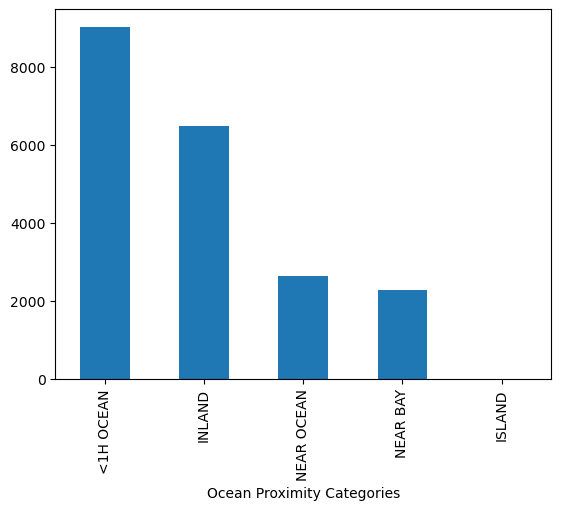

In [8]:
# plot bar chat to show the ocean_proximity categories
df['ocean_proximity'].value_counts().plot(kind='bar', xlabel='Ocean Proximity Categories')

The ISLAND category in ocean_proximity accounted for only 5 observations (~0.02% of the dataset), which is too small to provide meaningful predictive value. To prevent noise and unnecessary feature creation during one-hot encoding, these rows will be removed from the dataset.

In [9]:
# remove Island category from the ocean_proximity feature
df = df[df['ocean_proximity'] != 'ISLAND']

# confirm that the Island category has been removed from the ocean_proximity feature
print(df['ocean_proximity'].value_counts())
print(df.shape)

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
Name: count, dtype: int64
(20428, 10)


**Further investigate the relationship between the features and target variable**

Ocean proximity feature could be a valuable feature to our target variable. Generally, houses which are closer to the ocean, tend to be more expensive. Well, at least, this is the case in Toronto, Ontario! Let's dig a bit further to see if there are any correlations there.

<Axes: title={'center': 'California Housing Map'}, xlabel='longitude', ylabel='latitude'>

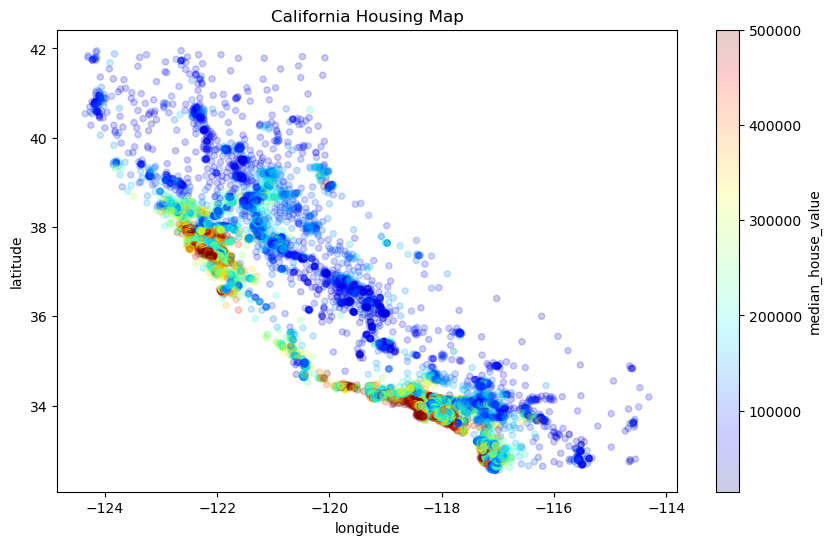

In [10]:
# plot the longitude and latitude data to visualize the California Housing Market
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, c='median_house_value', cmap=plt.get_cmap('jet'), figsize=(10,6), title='California Housing Map')

The initial prediction seems to be valid as districts gets closer to the shoreline, the median house value tends to be higher with a few exceptions.

<Axes: >

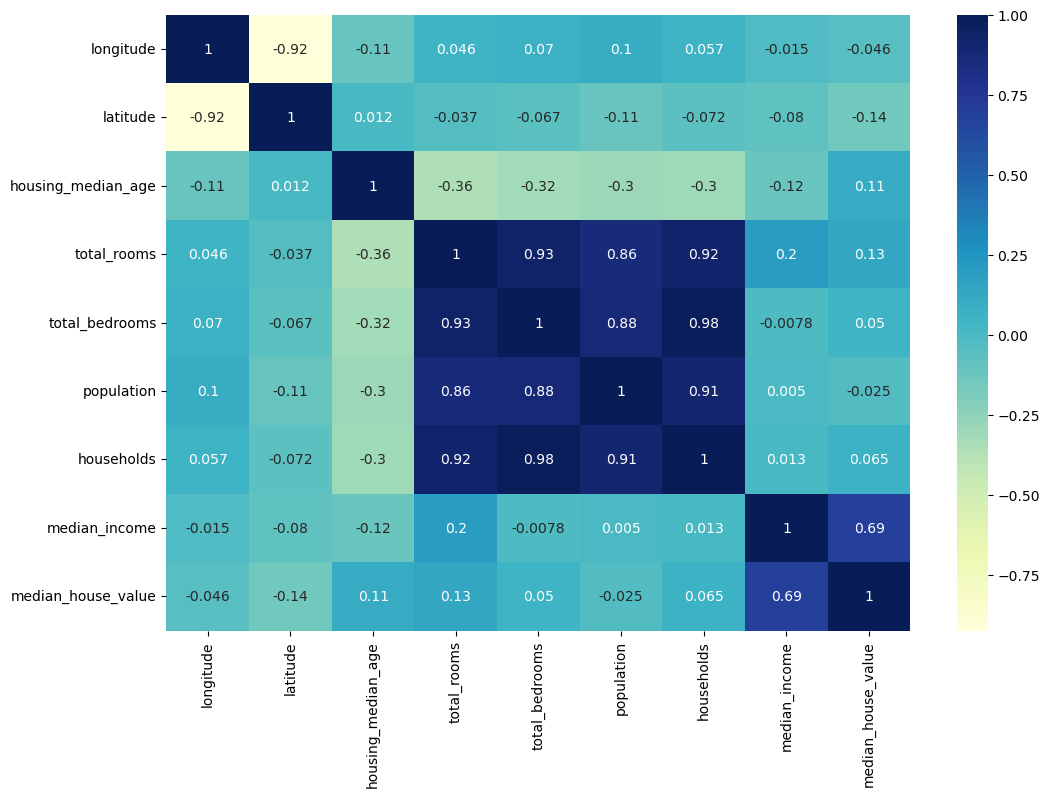

In [11]:
# plot a heatmap to visualize the correlations between the features and target variable
plt.figure(figsize=(12,8))
sns.heatmap(data=df.drop(columns='ocean_proximity').corr(), annot=True, cmap='YlGnBu')

In [12]:
# isolate coefficients for median_house_value
df_corr = df.drop(columns='ocean_proximity').corr()
df_corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688848
total_rooms           0.133516
housing_median_age    0.106077
households            0.065122
total_bedrooms        0.049792
population           -0.025069
longitude            -0.045642
latitude             -0.144312
Name: median_house_value, dtype: float64

**Check dataset for any outliers**

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

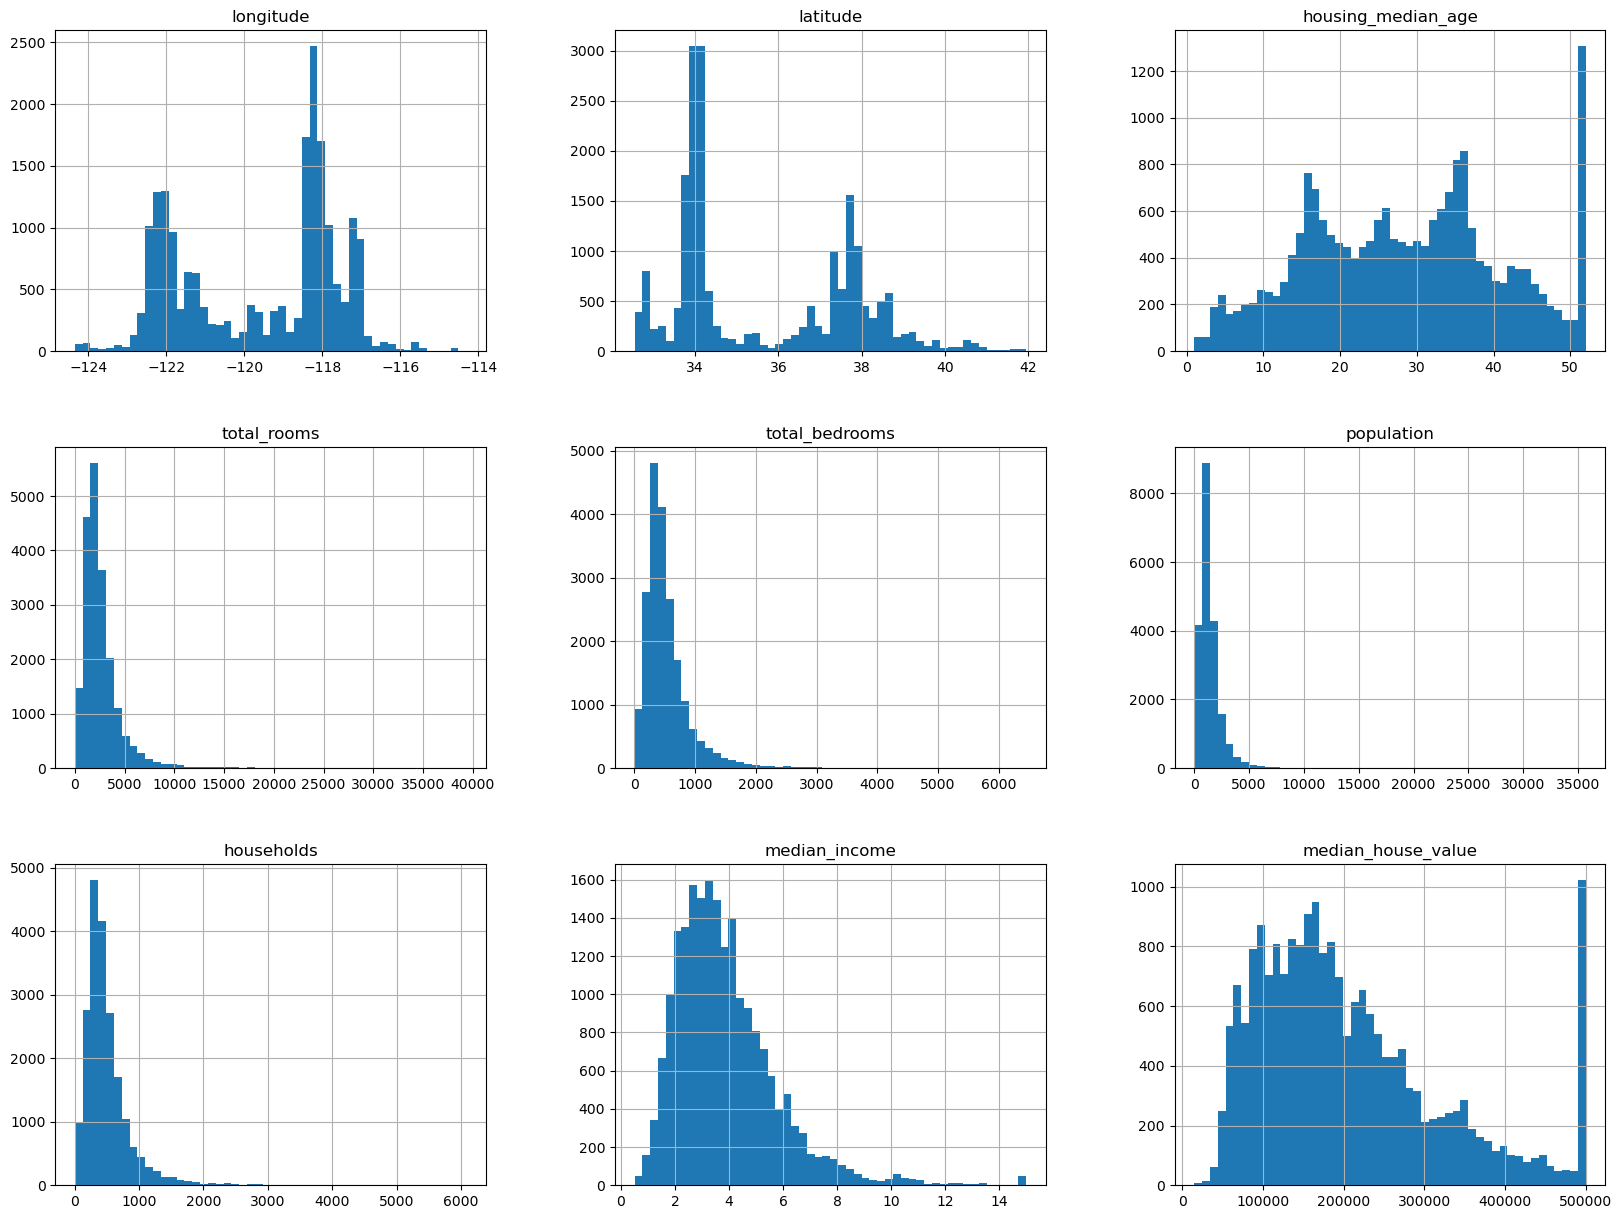

In [13]:
# plot histograms for target variable and all feautures except for ocean_proximity as these values are dummy variables 
df.drop(columns='ocean_proximity').hist(bins=50, figsize=(20,15))

longitude                Axes(0.125,0.653529;0.227941x0.226471)
latitude              Axes(0.398529,0.653529;0.227941x0.226471)
housing_median_age    Axes(0.672059,0.653529;0.227941x0.226471)
total_rooms              Axes(0.125,0.381765;0.227941x0.226471)
total_bedrooms        Axes(0.398529,0.381765;0.227941x0.226471)
population            Axes(0.672059,0.381765;0.227941x0.226471)
households                   Axes(0.125,0.11;0.227941x0.226471)
median_income             Axes(0.398529,0.11;0.227941x0.226471)
median_house_value        Axes(0.672059,0.11;0.227941x0.226471)
dtype: object

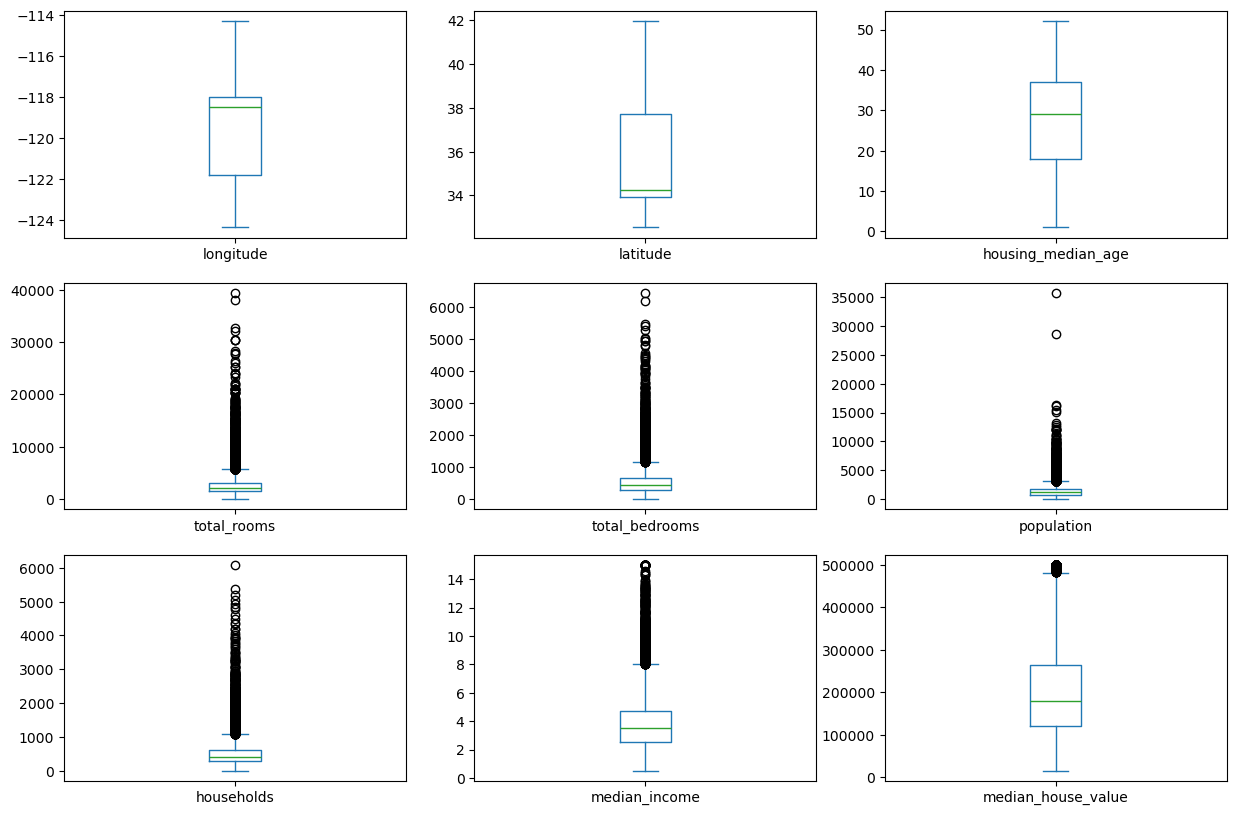

In [14]:
# plot boxplot diagrams
df.drop(columns='ocean_proximity').plot(kind='box', subplots=True, layout=(3, 3), figsize=(15, 10), sharex=False, sharey=False)

Columns in the dataset were investigated to identify potential outliers. Histograms and boxplots were plotted to visualize the distribution of values and detect anomalies. Features such as total_rooms, total_bedrooms, population, households, and median_income exhibited right-skewed distributions, which was reflected in their boxplots by longer right whiskers and numerous outlier points on the high-value end. Additionally, median_house_value showed a pronounced spike at 500,000, and housing_median_age peaked sharply at 50. This suggests that the dataset likely applied an upper cap at these values, meaning any observations exceeding those thresholds were recorded as exactly 500,001 or 52, respectively based on the max values. 

In the case of variables like total_rooms and total_bedrooms, these extreme values represent valid observations rather than erroneous data, as they correspond to genuine census block groups with unusually large apartment complexes, multi-unit dwellings, or high-end properties. Removing them would risk discarding important information about the housing stock in these areas, potentially biasing the model and weakening its ability to capture relationships in the upper range of the feature distribution. Instead of deletion, these values should be handled through appropriate transformations or scaling techniques.

Adjust the positively skewed data using log transformation in order to use models like linear regression

In [15]:
df['total_rooms'] = df['total_rooms'].apply(np.log1p)
df['total_bedrooms'] = df['total_bedrooms'].apply(np.log1p)
df['population'] = df['population'].apply(np.log1p)
df['households'] = df['households'].apply(np.log1p)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

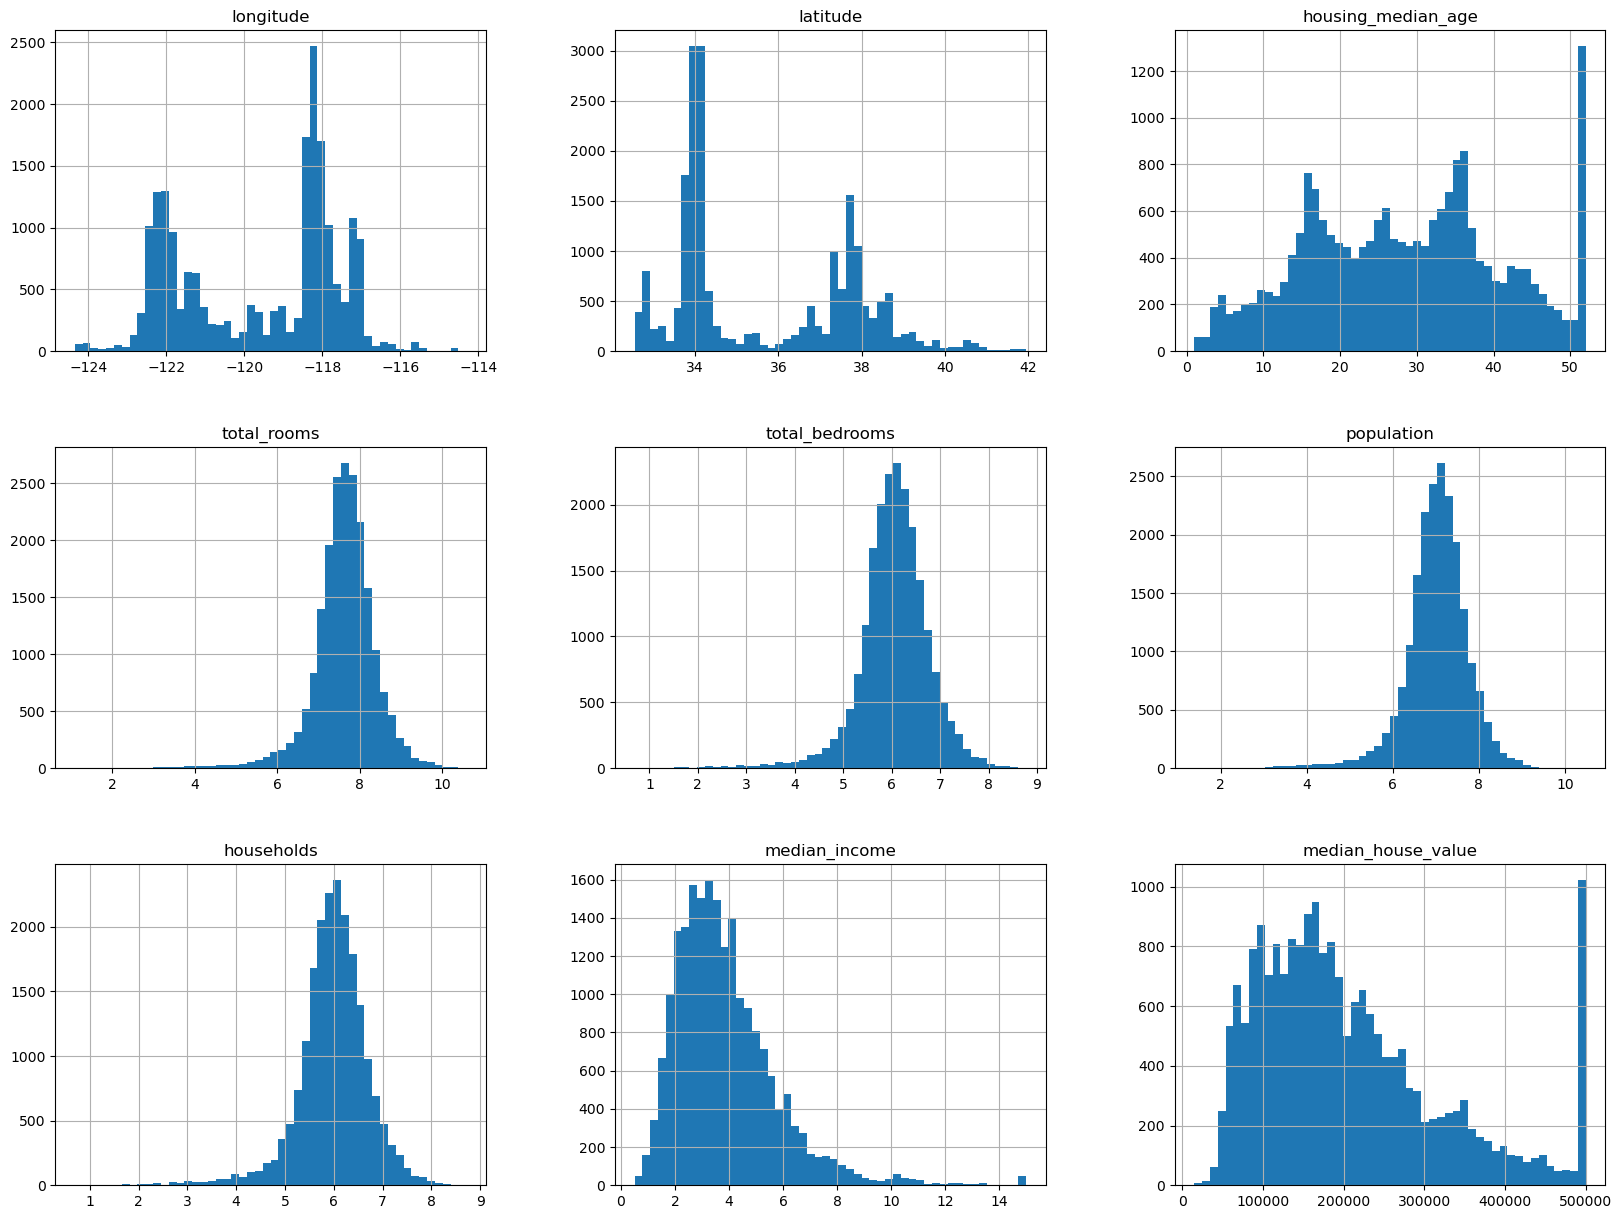

In [16]:
# confirmation of the application of log transformation
df.drop(columns='ocean_proximity').hist(bins=50, figsize=(20,15))

### Data Preparation 

In [17]:
# split the dataset for training/testing
X = df.drop(columns='median_house_value')
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [18]:
# confirm X_train and X_test splits
print(X_train.shape)
print(X_test.shape)

(14299, 9)
(6129, 9)


**Convert ocean_proximity features to numerical values**

In [19]:
ohe = OneHotEncoder(sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[['ocean_proximity']])
X_test_ohe = ohe.transform(X_test[['ocean_proximity']])

# convert to DataFrames with the correct column names and indices
ohe_cols = ohe.get_feature_names_out(['ocean_proximity'])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_cols, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_cols, index=X_test.index)

# merge with the rest of the dataset
X_train_final = pd.concat([X_train.drop(columns=['ocean_proximity']), X_train_ohe], axis=1)
X_test_final = pd.concat([X_test.drop(columns=['ocean_proximity']), X_test_ohe], axis=1)

**Apply Standard Scaler**

In [20]:
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

### Model Experimentation 🧪 

#### 1) Linear Regression Model ➗📈

In [21]:
model_lr = LinearRegression()
model_lr.fit(X_train_final, y_train)
y_pred = model_lr.predict(X_test_final)

In [22]:
# perform evaluations on the model performance

# Mean Squared Error
lr_mse_train = mean_squared_error(y_train, model_lr.predict(X_train_final))
lr_mse_test =  mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
lr_rmse_train = np.sqrt(lr_mse_train)
lr_rmse_test = np.sqrt(lr_mse_test)

print(f'LR Train R2 Score = {model_lr.score(X_train_final, y_train)}')
print(f'LR Test R2 Score = {model_lr.score(X_test_final, y_test)}\n')
print(f'LR Train RMSE Score = {lr_rmse_train}')
print(f'LR Test RMSE Score = {lr_rmse_test}')

LR Train R2 Score = 0.6715098954730025
LR Test R2 Score = 0.6669799037258264

LR Train RMSE Score = 66285.60786187417
LR Test RMSE Score = 66269.37783291603


#### 2) Random Forest Regressor Model 🌲🌳

In [23]:
model_rfr = RandomForestRegressor(random_state=42)
model_rfr.fit(X_train_final, y_train)
y_pred = model_rfr.predict(X_test_final)

In [24]:
# perform evaluations on the model performance

# Mean Squared Error
rfr_mse_train = mean_squared_error(y_train, model_rfr.predict(X_train_final))
rfr_mse_test =  mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rfr_rmse_train = np.sqrt(rfr_mse_train)
rfr_rmse_test = np.sqrt(rfr_mse_test)

print(f'RFR Train R2 Score = {model_rfr.score(X_train_final, y_train)}')
print(f'RFR Test R2 Score = {model_rfr.score(X_test_final, y_test)}\n')
print(f'RFR Train RMSE Score = {rfr_rmse_train}')
print(f'RFR Test RMSE Score = {rfr_rmse_test}')

RFR Train R2 Score = 0.9745323239485055
RFR Test R2 Score = 0.8194138277369121

RFR Train RMSE Score = 18456.644877891962
RFR Test RMSE Score = 48800.01085405052


#### 3) Extreme Gradient Boosting ⚡🌳

In [25]:
model_xgb = xgb.XGBRegressor(random_state=42)
model_xgb.fit(X_train_final, y_train)
y_pred = model_xgb.predict(X_test_final)

In [26]:
# perform evaluations on the model performance

# Mean Squared Error
xgb_mse_train = mean_squared_error(y_train, model_xgb.predict(X_train_final))
xgb_mse_test =  mean_squared_error(y_test, y_pred)

# # Root Mean Squared Error
xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_rmse_test = np.sqrt(xgb_mse_test)

print(f'XGB Train R2 Score = {model_xgb.score(X_train_final, y_train)}')
print(f'XGB Test R2 Score = {model_xgb.score(X_test_final, y_test)}\n')
print(f'XGB Train RMSE Score = {xgb_rmse_train}')
print(f'XGB Test RMSE Score = {xgb_rmse_test}')

XGB Train R2 Score = 0.9424320704062681
XGB Test R2 Score = 0.8255304932058678

XGB Train RMSE Score = 27749.068106568662
XGB Test RMSE Score = 47966.43469571677


### Model Comparison and Selection ⚖️

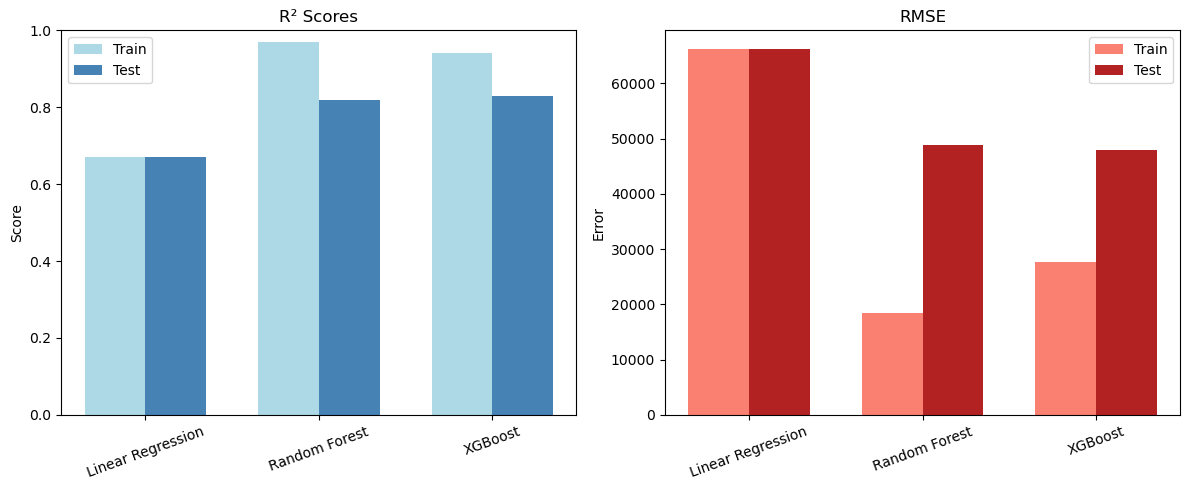

In [27]:
# compare the three models based on their metrics
models = ["Linear Regression", "Random Forest", "XGBoost"]

r2_train = [0.67, 0.97, 0.94]
r2_test  = [0.67, 0.82, 0.83]

rmse_train = [66285, 18456, 27749]
rmse_test  = [66269, 48800, 47966]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(x - width/2, r2_train, width, label="Train", color="lightblue")
plt.bar(x + width/2, r2_test,  width, label="Test", color="steelblue")
plt.xticks(x, models, rotation=20)
plt.title("R² Scores")
plt.ylim(0,1)
plt.ylabel("Score")
plt.legend()

plt.subplot(1,2,2)
plt.bar(x - width/2, rmse_train, width, label="Train", color="salmon")
plt.bar(x + width/2, rmse_test,  width, label="Test", color="firebrick")
plt.xticks(x, models, rotation=20)
plt.title("RMSE")
plt.ylabel("Error")
plt.legend()

plt.tight_layout()

Based on the above plots, XGBoost model was selected to move forward with hyperparameter tuning

In [28]:
# perform hyperparameter tuning on Model 3

param_grid = {
                'n_estimators': np.arange(200, 2000, 200),    
                'learning_rate': np.linspace(0.01, 0.08, 28),  
                'max_depth': np.arange(4, 7, 1),           
                'min_child_weight': np.arange(5, 11, 1),          
                'gamma': np.linspace(0.5, 2.0, 7),    
                'subsample': np.linspace(0.7, 0.95, 6),    
                'colsample_bytree': np.linspace(0.7, 0.95, 6),    
                'reg_alpha': [0, 0.01, 0.1, 1, 5],        
                'reg_lambda': [0.1, 1, 5, 10],
                'max_bin': [128, 256, 512]
            }

# perfrom cross validation and ensure to shuffle
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# for computing reasons, RandomizedSearchCV was chosen
random_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train_final, y_train)
print("Best Parameters (Randomized): ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters (Randomized):  {'subsample': np.float64(0.95), 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': np.int64(1800), 'min_child_weight': np.int64(8), 'max_depth': np.int64(6), 'max_bin': 256, 'learning_rate': np.float64(0.022962962962962963), 'gamma': np.float64(2.0), 'colsample_bytree': np.float64(0.8999999999999999)}


In [32]:
# predict model based on best parameters generated above
best_model = random_search.best_estimator_
y_pred_op = best_model.predict(X_test_final)

In [30]:
# perform evaluations on the model performance

# Mean Squared Error
xgb_op_mse_train = mean_squared_error(y_train, best_model.predict(X_train_final))
xgb_op_mse_test =  mean_squared_error(y_test, y_pred_op)

# # Root Mean Squared Error
xgb_op_rmse_train = np.sqrt(xgb_op_mse_train)
xgb_op_rmse_test = np.sqrt(xgb_op_mse_test)

print(f'XGB Train R2 Score = {best_model.score(X_train_final, y_train)}')
print(f'XGB Test R2 Score = {best_model.score(X_test_final, y_test)}\n')
print(f'XGB Train RMSE Score = {xgb_op_rmse_train}')
print(f'XGB Test RMSE Score = {xgb_op_rmse_test}')

XGB Train R2 Score = 0.943012716004743
XGB Test R2 Score = 0.840121924515182

XGB Train RMSE Score = 27608.77116519161
XGB Test RMSE Score = 45916.854370707275


#### **Model Performance Summary**

| Metric  | Train Score | Test Score | ✅ Summary |
|---------|-------------|------------|------------|
| **R²**  | 0.943       | 0.840      | Strong predictive power with good generalization |
| **RMSE**| 27.6K       | 45.9K      | Predictions are within ~9% of actual house values |


### Pickling the Trained Model 📦 

In [31]:
model=best_model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as xgb_model.pkl")

Model saved as xgb_model.pkl
